# Employment DATA EDA

This file aims to show the logic behind cleaning employment data.

First, let's load some libraries

In [1]:
import os
cdir = os.path.abspath(os.path.dirname("__file__"))

import sys
sys.path.insert(0, cdir + "/..")

In [2]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from custom_modules.organize import *
from custom_modules.roughEDA import *
import cPickle as pickle

import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data frame

In [3]:
df = pd.read_excel('../data/employment/GSS.xls')

In [4]:
df.head(1)

,Gss year for this respondent,Respondent id number,Labor force status,Number of hours worked last week,Number of hours usually work a week,Marital status,Respondents sex,Household members less than 6 yrs old,Household members 6 thru 12 yrs old,Household members 13 thru 17 yrs old,Household members 18 yrs and older,General happiness
0,1994,2,Working fulltime,40,Not applicable,Married,Male,0,0,0,2,Very happy


column names are long. use extract_variables function to extract variables. Then replace the columns names replece function.  **Need to incorprate this into data process class function**

In [5]:
variables = extract_variables('../data/employment/GSS.sps')
replace_variables(df,variables)

In [6]:
df.head(1)

,year,id_,wrkstat,hrs1,hrs2,marital,sex,babies,preteen,teens,adults,happy
0,1994,2,Working fulltime,40,Not applicable,Married,Male,0,0,0,2,Very happy


## EDA

In [7]:
df.shape

(30213, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30213 entries, 0 to 30212
Data columns (total 12 columns):
year       30212 non-null object
id_        30212 non-null object
wrkstat    30211 non-null object
hrs1       30211 non-null object
hrs2       30211 non-null object
marital    30211 non-null object
sex        30211 non-null object
babies     30211 non-null object
preteen    30211 non-null object
teens      30211 non-null object
adults     30211 non-null object
happy      30211 non-null object
dtypes: object(12)
memory usage: 3.0+ MB


###  Check working status column

In [9]:
df.wrkstat.value_counts(dropna=False)

Working fulltime    15421
Retired              4622
Keeping house        3354
Working parttime     3285
Unempl, laid off     1136
School                981
Other                 782
Temp not working      614
No answer              16
NaN                     2
Name: wrkstat, dtype: int64

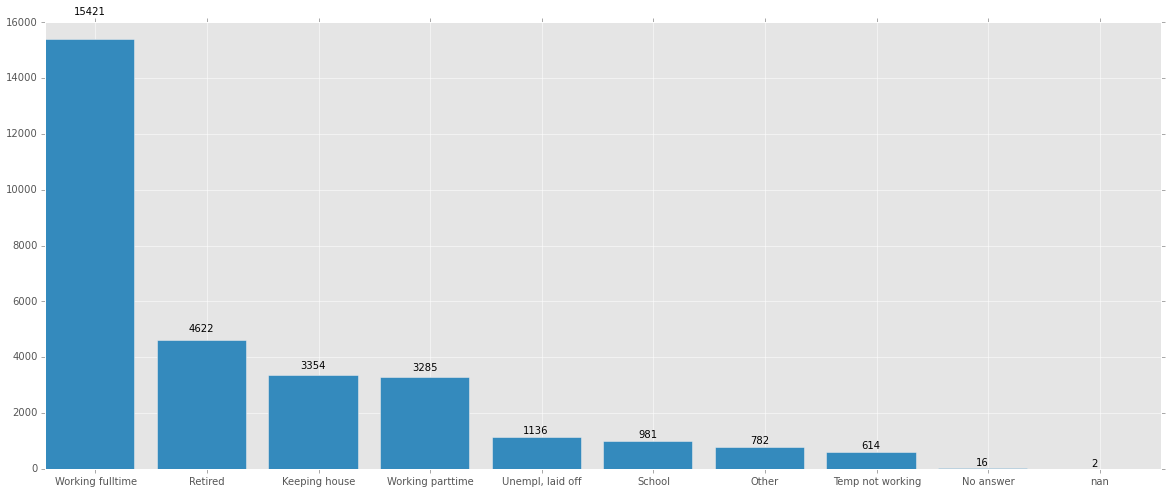

In [10]:
simple_bar(df.wrkstat,(20,8))

### Retired and school population are not group of interest for this study. Drop the retired and school rows.

In [11]:
df = df[df.wrkstat.apply(lambda x: x not in ['School','Retired'])]
df.shape

(24610, 12)

In [12]:
temp = df[df.hrs1=='Not applicable']

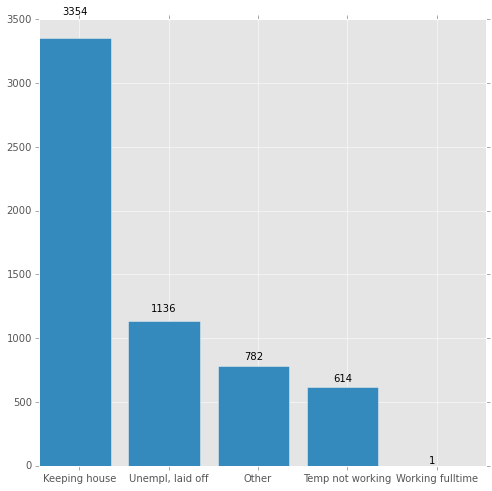

In [13]:
simple_bar(temp.wrkstat)

## Respondents who filled hrs1 "not applicable" are not working, so we can set "not applicable" as 0. Same will be applied to hrs 2

In [14]:
df['hrs1'].replace('Not applicable',0,inplace = True)

In [15]:
df['hrs2'].replace('Not applicable', 0, inplace = True)

In [16]:
df['hrs1'].unique()

array([40, 20, 35, 75, 0, 70, 48, 16, 51, 30, 37, 89, 38, 60, 80, 50, 25,
       55, 10, 44, 7, 36, 13, u'No answer', 33, 24, 45, 65, 23, 57, 58, 32,
       34, 43, 19, 6, 8, 49, 47, 26, 39, 42, 28, 76, 22, 46, 41, 56, 15,
       72, 54, 52, 14, 53, 31, u"Don't know", 3, 67, 12, 84, 4, 62, 29, 5,
       9, 82, 2, 27, 59, 18, 79, 85, 21, 17, 64, 68, 63, 11, 1, 66, 73, 74,
       61, 86, 87, 83, 69, 78, 77, 71, 88, nan], dtype=object)

In [17]:
df.hrs2.unique()

array([0, 30, 40, u'No answer', 45, 47, 50, 56, 60, 35, 55, 24, 48, 20, 46,
       36, 4, 12, 70, 52, 15, 25, 32, 6, 10, 7, 3, 42, 1, 43, 38, 5, 65, 8,
       44, 18, 89, 22, 41, 17, 16, 72, 28, 80, 75, 11, 27, 57, nan], dtype=object)

## replace "no answer" and "dont know" with np.nan

In [18]:
df[df.hrs1=="Don't know"]['hrs2'].unique()

array([0], dtype=object)

In [19]:
df.hrs1.replace(["Don't know","No answer"], np.nan, inplace=True)

In [20]:
df.hrs2.replace('No answer',np.nan, inplace=True)

In [21]:
df[['hrs1','hrs2']].apply(lambda x: x!=0).sum(axis = 1).argmax()

278

In [22]:
df.ix[278,:]

year             1994
id_               799
wrkstat     No answer
hrs1              NaN
hrs2              NaN
marital     No answer
sex            Female
babies              0
preteen             0
teens               0
adults              1
happy      Don't know
Name: 278, dtype: object

## hrs1 and hrs2 are not 0 at same time. we can combine them by adding them up, elementwise. then drop hrs2

In [23]:
df['whrs'] = df['hrs1'].values +df['hrs2'].values


## fill whrs nan with column mean

In [24]:
df.whrs.fillna(df.whrs.mean(),inplace= True)

## drop hrs1,hrs2

In [25]:
df.drop(['hrs1','hrs2'],axis=1,inplace=True)

## Now let's look at matrial status

In [26]:
df.marital.value_counts()

Married          12181
Never married     6393
Divorced          3949
Widowed           1185
Separated          889
No answer           11
Name: marital, dtype: int64

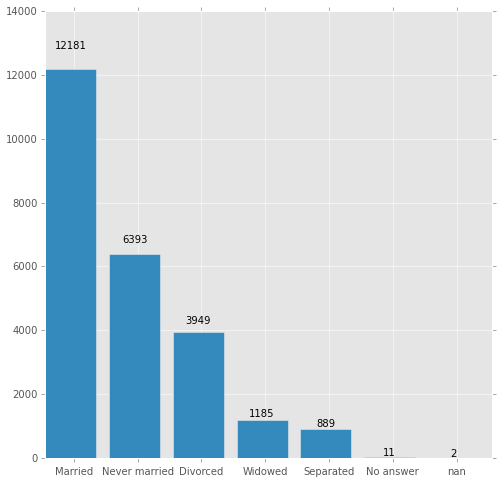

In [27]:
simple_bar(df.marital)

For now, split respondent into married and not married 

In [28]:
df['married'] = df.marital.apply(lambda x: x=="Married")

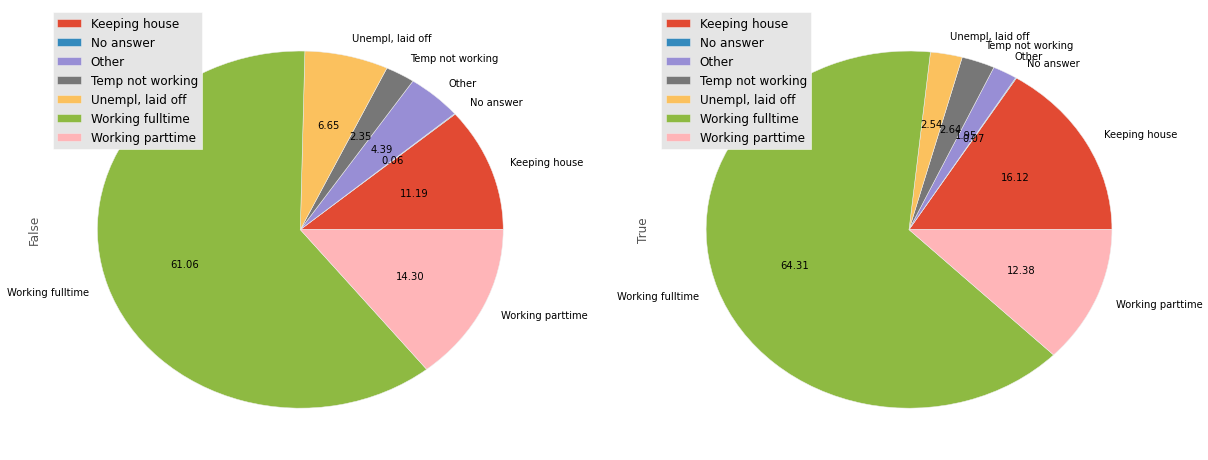

In [29]:
pie_chart(df.married,df.wrkstat)

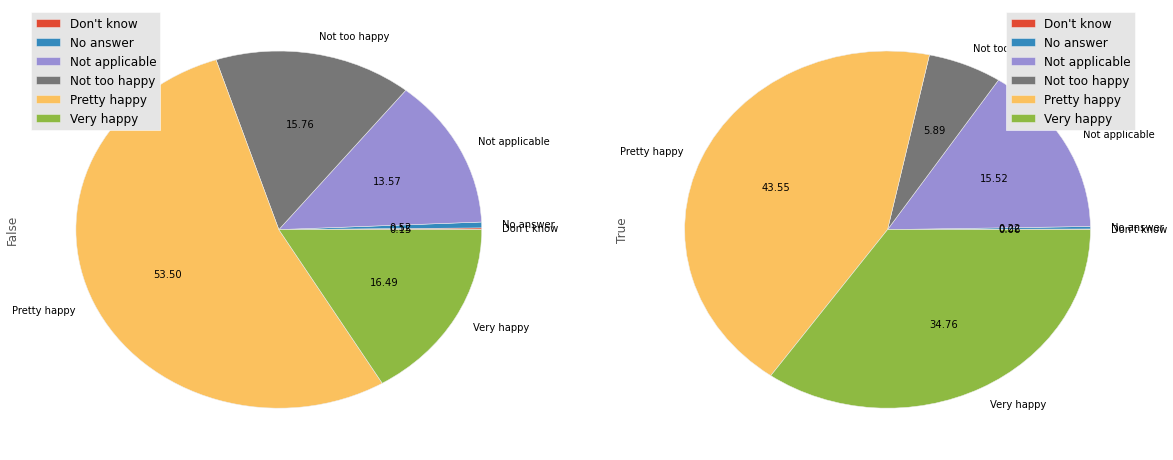

In [30]:
pie_chart(df.married,df.happy)

## will dummie this column eventually, no need to create new columns from this.

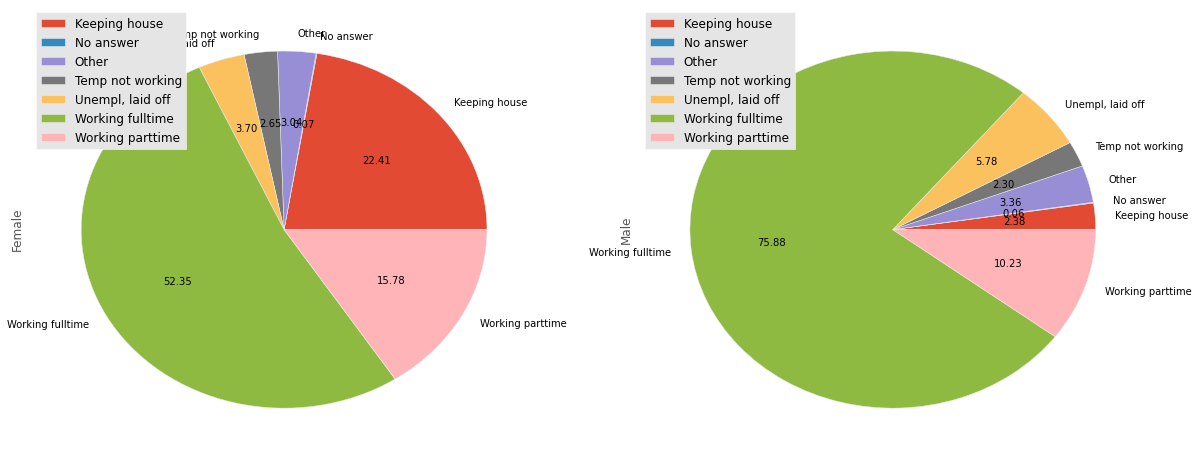

In [31]:
pie_chart(df.sex,df.wrkstat)

## This chart has pronounced contrast. Should save it or reconstruct it using plotly

now, check family status

In [32]:
cols = ['babies','preteen','teens','adults']
for c in cols:
    print c
    print df[c].value_counts()
    

babies
0            20433
1             2780
2             1016
No answer      188
3              165
4               20
5                4
6                2
Name: babies, dtype: int64
preteen
0            19711
1             3027
2             1359
3              282
No answer      186
4               31
5                6
6                5
8 or more        1
Name: preteen, dtype: int64
teens
0            20733
1             2748
2              830
No answer      182
3               94
4               18
5                2
7                1
Name: teens, dtype: int64
adults
2            13418
1             7630
3             2535
4              765
5              167
No answer       46
6               42
7                3
8 or more        2
Name: adults, dtype: int64


In [33]:
df.adults.min()

1

## adult column is useless, drop it

In [34]:
df.drop('adults', axis=1, inplace=True)

## convert babies, teens, preteens columns into booleans 

In [35]:
make_bool(df,['babies','preteen','teens'],0,"has")

In [36]:
df.columns

Index([u'year', u'id_', u'wrkstat', u'marital', u'sex', u'babies', u'preteen',
       u'teens', u'happy', u'whrs', u'married', u'has_babies', u'has_preteen',
       u'has_teens'],
      dtype='object')

In [37]:
df.drop(['babies','preteen','teens'],axis=1,inplace=True)

### pickle dataframe

In [38]:
with open('../data/employ.pkl','w') as f:
    pickle.dump(df,f)

## get dummies

In [39]:
work = pd.get_dummies(df.wrkstat)

In [40]:
work['Employed'] = work['Working fulltime']+work['Working parttime']

In [41]:
marital = pd.get_dummies(df.marital)

In [42]:
sex = pd.get_dummies(df.sex)

In [43]:
happy = pd.get_dummies(df.happy)

## Final Dataframe

In [44]:
dflis = ['year','id_','sex','whrs','married','has_babies','has_preteen','has_teens']
wrlis = ['Employed','Working fulltime','Working parttime']


In [45]:
fin_df = pd.concat([df.ix[:,dflis],work.ix[:,wrlis],marital,sex,happy], axis =1)

In [46]:
fin_df['has_kid'] = fin_df[['has_babies','has_preteen','has_teens']].sum(axis=1)>0

## More EDA

In [47]:
fin_df = fin_df[fin_df.year.apply(lambda x: x in range(1994,2016,2))]

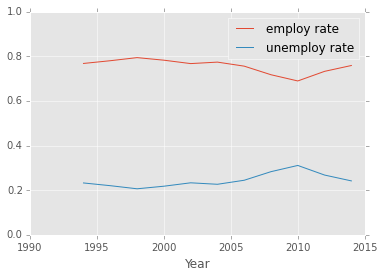

In [48]:
employ_r = fin_df.groupby('year')['Employed'].sum()/fin_df.groupby('year')['Employed'].count()
umemploy_r = 1 - employ_r
plt.plot(range(1994,2016,2),employ_r, label = 'employ rate')
plt.plot(range(1994,2016,2),umemploy_r, label = 'unemploy rate')
plt.ylim(0,1)
plt.xlabel('Year')
plt.legend()

## z-test is needed here to test if there's a significant diffference between ratios

In [49]:
emp_sex = pd.crosstab(fin_df.sex,fin_df.Employed)
emp_sex

Employed,0.0,1.0
sex,,
Female,4404,9416
Male,1498,9290


In [50]:
z_test(emp_sex)

(-32.778410234071636, 0.0)

In [51]:
women = fin_df[fin_df['Female']==1]
men = fin_df[fin_df['Female']==0]

(0, 1)

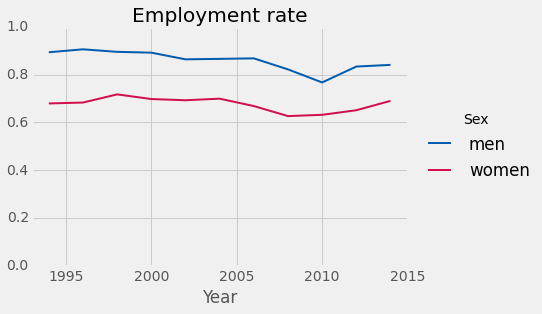

In [52]:
w_emp_r = women.groupby('year')['Employed'].sum()/women.groupby('year')['Employed'].count()
m_emp_r = men.groupby('year')['Employed'].sum()/men.groupby('year')['Employed'].count()

matplotlib.style.use('fivethirtyeight')
#plt.title('Figure 2 Employment Rate in Male and Female')
plt.title('Employment rate')
plt.plot(range(1994,2016,2),m_emp_r,label = 'men',lw =2, color = "#005CAF")
plt.plot(range(1994,2016,2),w_emp_r,label = 'women',lw=2, color = '#D0104C')
plt.legend(title = "Sex",loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Year',)
plt.xlim(1993,2015)
plt.ylim(0,1)
#plt.savefig('../imgs/employ/emp_sex.png',bbox_inches='tight')

In [53]:
# sample ratio z-test
import scipy.stats as scs
nw = women.shape[0] # number of women
emp_w = women.Employed.sum()  # number of employed women
p_w = emp_w/nw

nm = men.shape[0]       # number of men
emp_m = men.Employed.sum()    # number of employed men
p_m = emp_m/nm            # men employed rate

#z-test
pooled = (emp_w+emp_m)/(nw+nm)
s = np.sqrt(pooled*(1-pooled)*(1/nw+1/nm))
z = (p_w-p_m)/s
p = 1- scs.norm.cdf(abs(z))    # one tailed
print z,p

-32.7784102341 0.0


## Z-test

* women:
 with babies vs no baby 

In [54]:
w_baby = pd.crosstab(women.has_babies,women.Employed)

w_baby.columns = ['not_employed','employed']
w_baby.index = ['no_baby','has_baby']

w_baby


,not_employed,employed
no_baby,3340,7881
has_baby,1064,1535


In [55]:
z_test(w_baby)

(11.0152361792198, 0.0)

* women: with preteens vs no preteen

In [56]:
w_preteen = pd.crosstab(women.has_preteen,women.Employed)
w_preteen

Employed,0.0,1.0
has_preteen,,
False,3368,7401
True,1036,2015


In [57]:
z_test(w_preteen)

(2.8055812294147064, 0.0025112960089367364)

* women: teens vs no teen

In [58]:
w_teen = pd.crosstab(women.has_teens,women.Employed)
w_teen

Employed,0.0,1.0
has_teens,,
False,3709,7760
True,695,1656


In [59]:
z_test(w_teen)

(-2.632899007148275, 0.004232975841350517)

* Women: kids vs no kids

In [60]:
w_kid = pd.crosstab(women.has_kid,women.Employed)
w_kid

Employed,0.0,1.0
has_kid,,
False,2514,5666
True,1890,3750


In [61]:
z_test(w_kid)

(3.4435899081445851, 0.00028702284680293122)

In [62]:
def percent(df,col1,bool=True, group = 'year', col2 = 'Employed'):
    s = df[df[col1]==bool].groupby(group)[col2].sum()
    c = df[df[col1]==bool].groupby(group)[col2].count()
    n = s/c
    return n

In [63]:
yr_baby_w = percent(women,'has_babies')
yr_preteen_w = percent(women,'has_preteen')
yr_teens_w = percent(women,'has_teens')
yr_no_kid_w = percent(women,'has_kid',False)


In [64]:
yr_baby_m = percent(men,'has_babies')
yr_preteen_m = percent(men,'has_preteen')
yr_teens_m = percent(men,'has_teens')
yr_no_kid_m = percent(men,'has_kid',False)

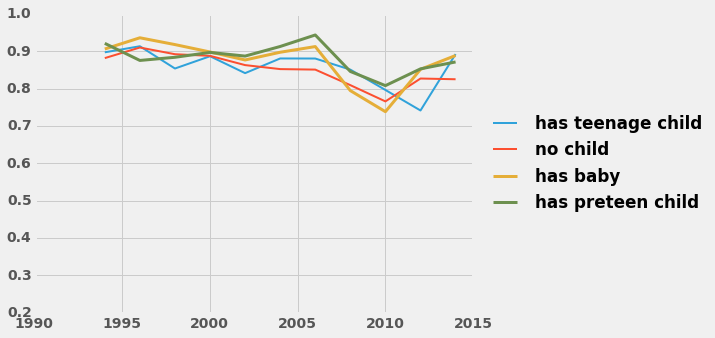

In [80]:
from matplotlib import rc

rc('font', weight='bold')
plt.figure(figsize=(7,5))
x = range(1994,2016,2)

plt.plot(x,yr_teens_m,label = 'has teenage child',lw = 2)
plt.plot(x,yr_no_kid_m,label='no child',lw =2)
plt.plot(x,yr_baby_m,label = 'has baby',lw = 3)
plt.plot(x,yr_preteen_m,label = 'has preteen child',lw =3)


# plt.plot(x,yr_teens_w,label = 'has teenage child',lw = 2)
# plt.plot(x,yr_no_kid_w,label='no child',lw =2)
# plt.plot(x,yr_baby_w,label = 'has baby',lw = 3)
# plt.plot(x,yr_preteen_w,label = 'has preteen child',lw =3)


plt.ylim(0.2,1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('../imgs/readme_figs/family',bbox_inches='tight')
plt.savefig('../imgs/employ/male_family',bbox_inches='tight')

## Conclusions :
 1. Men and Women have significant different employment rate
 2. Women with babies and preteen children are very likely leaving workforce. 

## Further Work:
1. polish several grapshs (plotly)
2. Try more statistical tests
3. If I have time, make a motiion bubble graph(x = working hours, y =happy, bubbles = respondents, moving = years) 

## Next Step:
1. Subset women with babies and preteen children for further study
2. Choose survey questions from GSS to as features
3. Try several classification models